Deseja considerar os amistosos na análise? (S/N):  s



Deseja que a análise seja baseada em:
1 - Números absolutos (total de vitórias)
2 - Índice (percentual de vitórias)


Digite 1 ou 2:  2
Digite o número mínimo de jogos para considerar na análise:  10



Os torneios com maior índice de vitórias do Brasil são:
               tournament  Jogos  Vitórias Índice de Vitórias
       Confederations Cup     33        23              69.7%
           FIFA World Cup    114        79              69.3%
        Copa Oswaldo Cruz     16        11              68.8%
Pan American Championship     16        11              68.8%
                 Friendly    438       299              68.3%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16348\762348785.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  torneios_ordenado['Índice_Num'] = torneios_ordenado['Índice de Vitórias'].str.rstrip('%').astype(float)


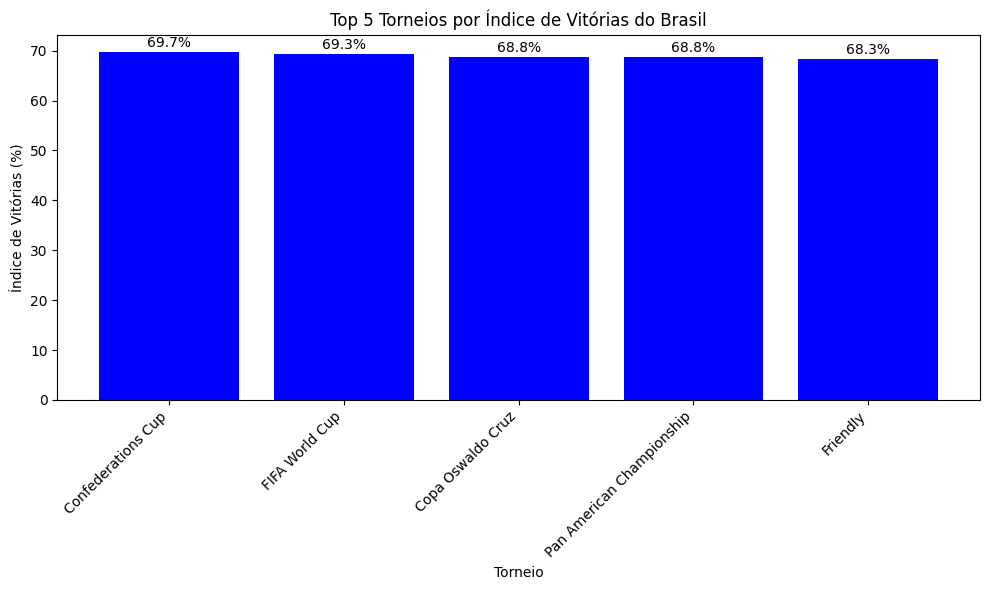


Resultados completos:
                  tournament  Jogos  Vitórias  Derrotas  Empates Índice de Vitórias
          Confederations Cup     33        23         5        5              69.7%
              FIFA World Cup    114        79        21       14              69.3%
           Copa Oswaldo Cruz     16        11         1        4              68.8%
   Pan American Championship     16        11         2        3              68.8%
                    Friendly    438       299        55       84              68.3%
FIFA World Cup qualification    137        87        16       34              63.5%
     Copa Bernardo O'Higgins     10         6         2        2              60.0%
                Copa América    195       114        50       31              58.5%
                    Gold Cup     14         8         4        2              57.1%
                   Copa Roca     23        11         9        3              47.8%
             Copa Rio Branco     18         8        

In [4]:
#1. Em qual competição internacional o Brasil é mais vitorioso (por índice de vitórias / jogos competidos)?

import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar o dataset de resultados
df = pd.read_csv('datasets\\results.csv')

# 2. Filtrar as partidas em que o Brasil participou (como mandante ou visitante)
df_brasil = df[(df['home_team'] == 'Brazil') | (df['away_team'] == 'Brazil')].copy()

# 3. Criar uma função para determinar o resultado da partida do ponto de vista do Brasil
def get_result(row):
    # Se o Brasil foi o time mandante (home_team)
    if row['home_team'] == 'Brazil':
        if row['home_score'] > row['away_score']:
            return 'Vitória'       # Brasil venceu
        elif row['home_score'] < row['away_score']:
            return 'Derrota'       # Brasil perdeu
        else:
            return 'Empate'        # Partida empatada
    # Se o Brasil foi o time visitante (away_team)
    else:
        if row['away_score'] > row['home_score']:
            return 'Vitória'       # Brasil venceu
        elif row['away_score'] < row['home_score']:
            return 'Derrota'       # Brasil perdeu
        else:
            return 'Empate'        # Partida empatada

# 4. Aplicar a função para determinar o resultado de cada partida do Brasil
df_brasil['Resultado'] = df_brasil.apply(get_result, axis=1)

# 5. Carregar o dataset de disputas de pênaltis
df_shootouts = pd.read_csv('datasets\\shootouts.csv')

# 6. Mesclar os datasets para identificar partidas decididas nos pênaltis
df_merged = pd.merge(df_brasil, df_shootouts, on=['date', 'home_team', 'away_team'], how='left')

# 7. Criar uma função para ajustar o resultado em caso de disputa de pênaltis
def adjust_for_shootouts(row):
    # Verifica se o resultado foi empate e se houve disputa de pênaltis
    if row['Resultado'] == 'Empate' and pd.notna(row['winner']):
        if row['winner'] == 'Brazil':
            return 'Vitória'       # Brasil venceu nos pênaltis
        else:
            return 'Derrota'       # Brasil perdeu nos pênaltis
    else:
        return row['Resultado']    # Mantém o resultado original

# 8. Aplicar a função para ajustar os resultados com base nas disputas de pênaltis
df_merged['Resultado_Final'] = df_merged.apply(adjust_for_shootouts, axis=1)

# 9. Perguntar ao usuário se deseja considerar os amistosos
considerar_amistosos = input("Deseja considerar os amistosos na análise? (S/N): ").strip().upper()

# 10. Filtrar as partidas com base na escolha do usuário
if considerar_amistosos == 'N':
    # Excluir partidas amistosas para focar em competições internacionais oficiais
    df_final = df_merged[df_merged['tournament'] != 'Friendly']
elif considerar_amistosos == 'S':
    # Incluir todas as partidas, incluindo amistosos
    df_final = df_merged.copy()
else:
    print("Opção inválida. Considerando apenas partidas não amistosas por padrão.")
    df_final = df_merged[df_merged['tournament'] != 'Friendly']

# 11. Perguntar ao usuário se deseja a resposta em números absolutos ou por índice
print("\nDeseja que a análise seja baseada em:")
print("1 - Números absolutos (total de vitórias)")
print("2 - Índice (percentual de vitórias)")
while True:
    opcao_analise = input("Digite 1 ou 2: ").strip()
    if opcao_analise in ['1', '2']:
        break
    else:
        print("Opção inválida. Por favor, digite 1 ou 2.")

# 12. Agrupar os dados por torneio e calcular o total de jogos, vitórias, derrotas e empates
torneios = df_final.groupby('tournament').agg(
    Jogos=('Resultado_Final', 'count'),
    Vitórias=('Resultado_Final', lambda x: (x == 'Vitória').sum()),
    Derrotas=('Resultado_Final', lambda x: (x == 'Derrota').sum()),
    Empates=('Resultado_Final', lambda x: (x == 'Empate').sum())
).reset_index()

# 13. Se a análise for por índice, calcular o percentual de vitórias
if opcao_analise == '2':
    # Calcular o índice de vitórias
    torneios['Índice de Vitórias'] = (torneios['Vitórias'] / torneios['Jogos']) * 100
    # Arredondar para uma casa decimal e adicionar o símbolo '%'
    torneios['Índice de Vitórias'] = torneios['Índice de Vitórias'].round(1).astype(str) + '%'
    # Perguntar ao usuário o número mínimo de jogos para a análise
    while True:
        try:
            numero_minimo_jogos = int(input("Digite o número mínimo de jogos para considerar na análise: "))
            break
        except ValueError:
            print("Por favor, insira um número inteiro válido.")
    # Filtrar torneios com o número mínimo de jogos
    torneios_ordenado = torneios[torneios['Jogos'] >= numero_minimo_jogos]
    # Ordenar pelo índice de vitórias (removendo o símbolo '%' para ordenação correta)
    torneios_ordenado['Índice_Num'] = torneios_ordenado['Índice de Vitórias'].str.rstrip('%').astype(float)
    torneios_ordenado = torneios_ordenado.sort_values(by='Índice_Num', ascending=False)
    # Remover a coluna auxiliar
    torneios_ordenado.drop(columns='Índice_Num', inplace=True)
    # Responder diretamente à pergunta
    print("\nOs torneios com maior índice de vitórias do Brasil são:")
    print(torneios_ordenado[['tournament', 'Jogos', 'Vitórias', 'Índice de Vitórias']].head(5).to_string(index=False))
else:
    # Ordenar pelo número absoluto de vitórias
    torneios_ordenado = torneios.sort_values(by='Vitórias', ascending=False)
    # Responder diretamente à pergunta
    print("\nOs torneios com mais vitórias do Brasil são:")
    print(torneios_ordenado[['tournament', 'Jogos', 'Vitórias']].head(5).to_string(index=False))

# 14. Exibir o gráfico de barras com o top 5
plt.figure(figsize=(10,6))
if opcao_analise == '2':
    top5 = torneios_ordenado.head(5).copy()
    # Remover o símbolo '%' para plotar
    top5['Índice_Num'] = top5['Índice de Vitórias'].str.rstrip('%').astype(float)
    plt.bar(top5['tournament'], top5['Índice_Num'], color='blue')
    plt.ylabel('Índice de Vitórias (%)')
    plt.title('Top 5 Torneios por Índice de Vitórias do Brasil')
    # Adicionar os valores acima das barras
    for i, v in enumerate(top5['Índice_Num']):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
else:
    top5 = torneios_ordenado.head(5)
    plt.bar(top5['tournament'], top5['Vitórias'], color='green')
    plt.ylabel('Número de Vitórias')
    plt.title('Top 5 Torneios com Mais Vitórias do Brasil')
    # Adicionar os valores acima das barras
    for i, v in enumerate(top5['Vitórias']):
        plt.text(i, v + 0.5, str(v), ha='center')
plt.xlabel('Torneio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 15. Exibir os resultados finais completos
print("\nResultados completos:")
if opcao_analise == '2':
    print(torneios_ordenado[['tournament', 'Jogos', 'Vitórias', 'Derrotas', 'Empates', 'Índice de Vitórias']].to_string(index=False))
else:
    print(torneios_ordenado[['tournament', 'Jogos', 'Vitórias', 'Derrotas', 'Empates']].to_string(index=False))


In [6]:
#2. Qual o time mais vitorioso em cada competição internacional?

import pandas as pd

# 1. Carregar os datasets
results = pd.read_csv('datasets\\results.csv')
shootouts = pd.read_csv('datasets\\shootouts.csv')

# 2. Carregar todas as partidas, incluindo amistosos
df = results.copy()

# 3. Ajustar resultados para disputas de pênaltis
# 3.1 Mesclar o dataset de resultados com o de shootouts
df_merged = pd.merge(df, shootouts, on=['date', 'home_team', 'away_team'], how='left')

# 3.2 Criar uma função para determinar o resultado final da partida
def get_match_result(row):
    # Verificar se houve disputa de pênaltis
    if pd.notna(row['winner']):
        if row['winner'] == row['home_team']:
            return row['home_team']
        else:
            return row['away_team']
    else:
        # Se não houve pênaltis, determinar o vencedor pelo placar
        if row['home_score'] > row['away_score']:
            return row['home_team']
        elif row['home_score'] < row['away_score']:
            return row['away_team']
        else:
            return 'Empate'

# 3.3 Aplicar a função para obter o resultado final
df_merged['vencedor'] = df_merged.apply(get_match_result, axis=1)

# 4. Perguntar ao usuário se deseja o maior número absoluto de vitórias ou o maior índice de vitórias
print("Escolha o critério para determinar o time mais vitorioso em cada competição:")
print("1 - Maior número absoluto de vitórias")
print("2 - Maior índice de vitórias")
while True:
    criterio = input("Digite 1 ou 2: ").strip()
    if criterio == '1' or criterio == '2':
        break
    else:
        print("Opção inválida. Por favor, digite 1 ou 2.")

# 5. Se o usuário escolheu o maior índice de vitórias, perguntar o número mínimo de jogos
if criterio == '2':
    while True:
        try:
            numero_minimo_jogos = int(input("Digite o número mínimo de jogos para considerar na análise: "))
            break
        except ValueError:
            print("Por favor, insira um número inteiro válido.")

# 6. Analisar cada torneio
torneios = df_merged['tournament'].unique()

# 6.1 Criar uma lista para armazenar os resultados
resultados = []

for torneio in torneios:
    # Filtrar partidas do torneio atual
    partidas_torneio = df_merged[df_merged['tournament'] == torneio]
    
    # Obter todos os times que participaram
    times = pd.unique(partidas_torneio[['home_team', 'away_team']].values.ravel('K'))
    
    # Criar uma lista para estatísticas dos times
    estatisticas_times = []

    for time in times:
        # Filtrar partidas do time no torneio
        partidas_time = partidas_torneio[
            (partidas_torneio['home_team'] == time) | (partidas_torneio['away_team'] == time)
        ]

        # Contar o número de jogos
        jogos = len(partidas_time)
        
        # Contar o número de vitórias
        vitorias = partidas_time['vencedor'].value_counts().get(time, 0)
        
        # Calcular o índice de vitórias
        indice_vitorias = vitorias / jogos if jogos > 0 else 0
        
        # Se o critério for índice de vitórias, aplicar o filtro do número mínimo de jogos
        if criterio == '2' and jogos < numero_minimo_jogos:
            continue  # Pula para o próximo time
        
        # Adicionar ao DataFrame de estatísticas
        estatisticas_times.append({
            'time': time,
            'jogos': jogos,
            'vitórias': vitorias,
            'índice de vitórias': indice_vitorias
        })
    
    # Verificar se há dados para o torneio
    if estatisticas_times:
        # Criar DataFrame de estatísticas
        df_estatisticas = pd.DataFrame(estatisticas_times)
        
        if criterio == '1':
            # Ordenar pelo número absoluto de vitórias em ordem decrescente
            df_estatisticas = df_estatisticas.sort_values(
                by=['vitórias', 'jogos'], ascending=[False, False]
            )
        else:
            # Ordenar pelo índice de vitórias em ordem decrescente
            df_estatisticas = df_estatisticas.sort_values(
                by=['índice de vitórias', 'jogos'], ascending=[False, False]
            )
        
        # Selecionar o time com maior valor de acordo com o critério
        time_mais_vitorioso = df_estatisticas.iloc[0]
        
        # Adicionar aos resultados
        resultados.append({
            'torneio': torneio,
            'time': time_mais_vitorioso['time'],
            'jogos': int(time_mais_vitorioso['jogos']),
            'vitórias': int(time_mais_vitorioso['vitórias']),
            'índice de vitórias': f"{(time_mais_vitorioso['índice de vitórias'] * 100):.1f}%"
        })

# 7. Criar DataFrame dos resultados e exibir
df_resultados = pd.DataFrame(resultados)

# Ordenar por ordem alfabética dos torneios
df_resultados = df_resultados.sort_values(by='torneio')

# 8. Exibir os resultados
print("\nTime mais vitorioso em cada competição internacional:")
print(df_resultados.to_string(index=False))


Escolha o critério para determinar o time mais vitorioso em cada competição:
1 - Maior número absoluto de vitórias
2 - Maior índice de vitórias


Digite 1 ou 2:  2
Digite o número mínimo de jogos para considerar na análise:  10



Time mais vitorioso em cada competição internacional:
                                   torneio                 time  jogos  vitórias índice de vitórias
                           ABCS Tournament             Suriname     10         7              70.0%
                             AFC Asian Cup               Israel     13         9              69.2%
               AFC Asian Cup qualification         Saudi Arabia     32        27              84.4%
                         AFC Challenge Cup          North Korea     14        11              78.6%
           AFC Challenge Cup qualification          Afghanistan     10         6              60.0%
                          AFF Championship             Thailand     84        53              63.1%
            AFF Championship qualification              Myanmar     10         8              80.0%
                    African Cup of Nations              Nigeria    103        63              61.2%
      African Cup of Nations qualification   

Deseja incluir amistosos na análise? (S/N):  S



Escolha o critério para determinar a década mais vitoriosa do Brasil:
1 - Maior número absoluto de vitórias
2 - Maior índice de vitórias


Digite 1 ou 2:  1



Década mais vitoriosa do Brasil:
     Década  Jogos  Vitórias  Índice de Vitórias (%)
1990 - 1999    160       108                    67.5
2000 - 2009    159       101                    63.5
2010 - 2019    142        99                    69.7
1960 - 1969    114        77                    67.5
1980 - 1989    115        72                    62.6
1970 - 1979    101        67                    66.3
1950 - 1959     95        61                    64.2
2020 - 2029     54        35                    64.8
1940 - 1949     42        24                    57.1
1930 - 1939     24        14                    58.3
1920 - 1929     23        10                    43.5
1910 - 1919     15         6                    40.0


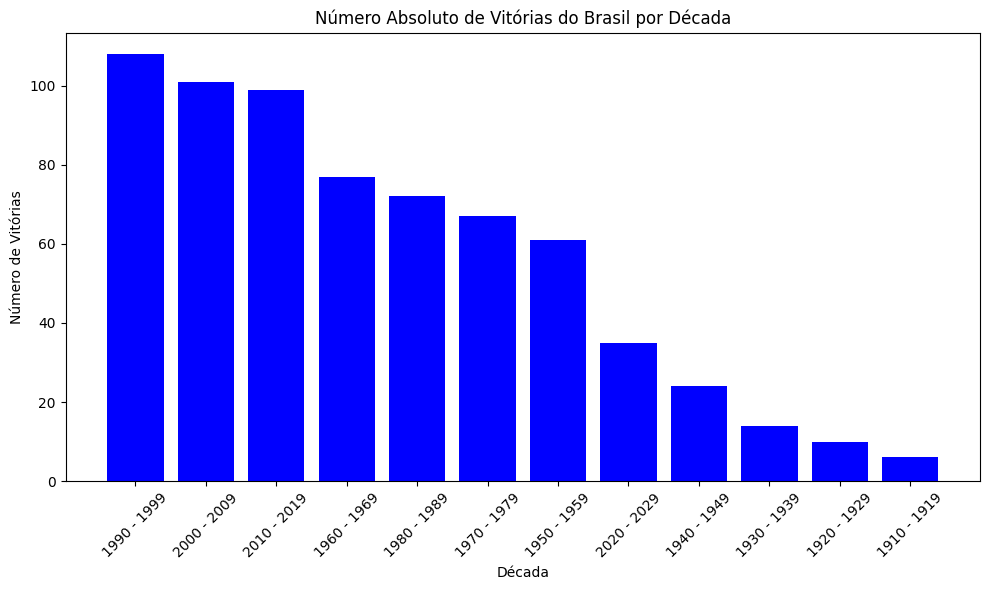

In [7]:
#3. Qual a década mais vitoriosa do Brasil, incluindo amistosos? (Dica: esse seria legal ver um gráfico de barras do índice de vitórias)

import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar os datasets
results = pd.read_csv('datasets\\results.csv')
shootouts = pd.read_csv('datasets\\shootouts.csv')

# 2. Filtrar as partidas em que o Brasil participou (como mandante ou visitante)
df_brasil = results[(results['home_team'] == 'Brazil') | (results['away_team'] == 'Brazil')].copy()

# 3. Ajustar os resultados para disputas de pênaltis
# 3.1 Mesclar o dataset de resultados com o de shootouts
df_merged = pd.merge(df_brasil, shootouts, on=['date', 'home_team', 'away_team'], how='left')

# 3.2 Criar uma função para determinar o resultado final da partida
def get_match_result(row):
    # Verificar se houve disputa de pênaltis
    if pd.notna(row['winner']):
        if row['winner'] == 'Brazil':
            return 'Vitória'
        else:
            return 'Derrota'
    else:
        # Determinar o resultado pelo placar
        if row['home_team'] == 'Brazil':
            if row['home_score'] > row['away_score']:
                return 'Vitória'
            elif row['home_score'] < row['away_score']:
                return 'Derrota'
            else:
                return 'Empate'
        else:
            if row['away_score'] > row['home_score']:
                return 'Vitória'
            elif row['away_score'] < row['home_score']:
                return 'Derrota'
            else:
                return 'Empate'

# 3.3 Aplicar a função para obter o resultado final
df_merged['Resultado'] = df_merged.apply(get_match_result, axis=1)

# 4. Perguntar ao usuário se deseja incluir amistosos
incluir_amistosos = input("Deseja incluir amistosos na análise? (S/N): ").strip().upper()

# 5. Filtrar as partidas com base na escolha do usuário
if incluir_amistosos == 'N':
    df_final = df_merged[df_merged['tournament'] != 'Friendly'].copy()
elif incluir_amistosos == 'S':
    df_final = df_merged.copy()
else:
    print("Opção inválida. Considerando apenas partidas não amistosas por padrão.")
    df_final = df_merged[df_merged['tournament'] != 'Friendly'].copy()

# 6. Perguntar ao usuário se deseja organizar por número absoluto de vitórias ou índice de vitórias
print("\nEscolha o critério para determinar a década mais vitoriosa do Brasil:")
print("1 - Maior número absoluto de vitórias")
print("2 - Maior índice de vitórias")
while True:
    criterio = input("Digite 1 ou 2: ").strip()
    if criterio == '1' or criterio == '2':
        break
    else:
        print("Opção inválida. Por favor, digite 1 ou 2.")

# 7. Converter a coluna 'date' para datetime
df_final['date'] = pd.to_datetime(df_final['date'])

# 8. Criar uma função para formatar a década
def format_decade(year):
    decade_start = (year // 10) * 10
    decade_end = decade_start + 9
    return f"{decade_start} - {decade_end}"

# 9. Aplicar a função para criar a coluna 'Década'
df_final['Década'] = df_final['date'].dt.year.apply(format_decade)

# 10. Agrupar os dados por década
grupos_decadas = df_final.groupby('Década')

# 11. Calcular as estatísticas por década
estatisticas_decadas = grupos_decadas.agg(
    Jogos=('Resultado', 'count'),
    Vitórias=('Resultado', lambda x: (x == 'Vitória').sum())
).reset_index()

# 12. Calcular o índice de vitórias
estatisticas_decadas['Índice de Vitórias'] = estatisticas_decadas['Vitórias'] / estatisticas_decadas['Jogos']

# 13. Organizar os dados de acordo com o critério escolhido
if criterio == '1':
    # Ordenar pelo número absoluto de vitórias
    estatisticas_decadas = estatisticas_decadas.sort_values(by='Vitórias', ascending=False)
else:
    # Ordenar pelo índice de vitórias
    estatisticas_decadas = estatisticas_decadas.sort_values(by='Índice de Vitórias', ascending=False)

# 14. Formatar a coluna 'Índice de Vitórias' como porcentagem
estatisticas_decadas['Índice de Vitórias (%)'] = (estatisticas_decadas['Índice de Vitórias'] * 100).round(1)
# Remover a coluna antiga
estatisticas_decadas = estatisticas_decadas.drop(columns='Índice de Vitórias')

# 15. Exibir os resultados
print("\nDécada mais vitoriosa do Brasil:")
print(estatisticas_decadas.to_string(index=False))

# 16. Exibir o gráfico de barras para ambos os critérios
plt.figure(figsize=(10,6))

if criterio == '1':
    # Gráfico para número absoluto de vitórias
    plt.bar(estatisticas_decadas['Década'], estatisticas_decadas['Vitórias'], color='blue')
    plt.ylabel('Número de Vitórias')
    plt.title('Número Absoluto de Vitórias do Brasil por Década')
else:
    # Gráfico para índice de vitórias
    plt.bar(estatisticas_decadas['Década'], estatisticas_decadas['Índice de Vitórias (%)'], color='green')
    plt.ylabel('Índice de Vitórias (%)')
    plt.title('Índice de Vitórias do Brasil por Década')

plt.xlabel('Década')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Deseja incluir amistosos na análise? (S/N):  s



Escolha o critério para determinar os times que mais venceram o Brasil:
1 - Maior número absoluto de vitórias sobre o Brasil
2 - Maior índice de vitórias sobre o Brasil


Digite 1 ou 2:  2
Digite o número mínimo de jogos para considerar na análise:  10



Times que mais venceram o Brasil:
    Adversário  Jogos  Derrotas do Brasil  Vitórias do Brasil  Empates  Índice de Derrotas (%)
        France     16                   6                   7        3                    37.5
     Argentina    109                  40                  46       23                    36.7
   Netherlands     12                   4                   4        4                    33.3
         Italy     16                   5                   9        2                    31.2
       Uruguay     78                  23                  39       16                    29.5
        Mexico     42                  10                  25        7                    23.8
       Germany     23                   5                  13        5                    21.7
         Spain     10                   2                   5        3                    20.0
   Switzerland     10                   2                   4        4                    20.0
      Portugal 

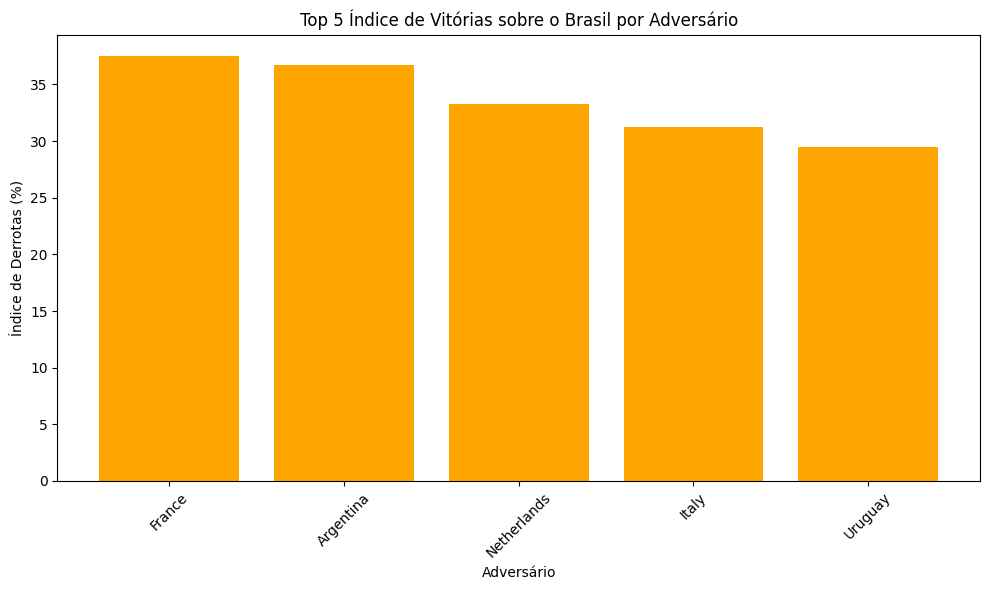

In [2]:
#4. Qual time mais venceu o Brasil (incluindo amistosos)?

import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar os datasets
results = pd.read_csv('datasets\\results.csv')
shootouts = pd.read_csv('datasets\\shootouts.csv')

# 2. Filtrar as partidas em que o Brasil participou (como mandante ou visitante)
df_brasil = results[(results['home_team'] == 'Brazil') | (results['away_team'] == 'Brazil')].copy()

# 3. Ajustar os resultados para disputas de pênaltis
# 3.1 Mesclar o dataset de resultados com o de shootouts
df_merged = pd.merge(df_brasil, shootouts, on=['date', 'home_team', 'away_team'], how='left')

# 3.2 Criar uma função para determinar o resultado final do ponto de vista do Brasil
def get_match_result(row):
    # Verificar se houve disputa de pênaltis
    if pd.notna(row['winner']):
        if row['winner'] == 'Brazil':
            return 'Vitória'
        else:
            return 'Derrota'
    else:
        # Determinar o resultado pelo placar
        if row['home_team'] == 'Brazil':
            if row['home_score'] > row['away_score']:
                return 'Vitória'
            elif row['home_score'] < row['away_score']:
                return 'Derrota'
            else:
                return 'Empate'
        else:
            if row['away_score'] > row['home_score']:
                return 'Vitória'
            elif row['away_score'] < row['home_score']:
                return 'Derrota'
            else:
                return 'Empate'

# 3.3 Aplicar a função para obter o resultado final
df_merged['Resultado'] = df_merged.apply(get_match_result, axis=1)

# 4. Perguntar ao usuário se deseja incluir amistosos
incluir_amistosos = input("Deseja incluir amistosos na análise? (S/N): ").strip().upper()

# 5. Filtrar as partidas com base na escolha do usuário
if incluir_amistosos == 'N':
    df_final = df_merged[df_merged['tournament'] != 'Friendly'].copy()
elif incluir_amistosos == 'S':
    df_final = df_merged.copy()
else:
    print("Opção inválida. Considerando apenas partidas não amistosas por padrão.")
    df_final = df_merged[df_merged['tournament'] != 'Friendly'].copy()

# 6. Perguntar ao usuário se deseja organizar por número absoluto de derrotas ou índice de derrotas
print("\nEscolha o critério para determinar os times que mais venceram o Brasil:")
print("1 - Maior número absoluto de vitórias sobre o Brasil")
print("2 - Maior índice de vitórias sobre o Brasil")
while True:
    criterio = input("Digite 1 ou 2: ").strip()
    if criterio == '1' or criterio == '2':
        break
    else:
        print("Opção inválida. Por favor, digite 1 ou 2.")

# 7. Se o usuário escolher o índice, perguntar o número mínimo de jogos
if criterio == '2':
    while True:
        try:
            numero_minimo_jogos = int(input("Digite o número mínimo de jogos para considerar na análise: "))
            break
        except ValueError:
            print("Por favor, insira um número inteiro válido.")

# 8. Identificar os adversários e calcular as estatísticas
# 8.1 Criar uma lista para armazenar os resultados
estatisticas_adversarios = []

# 8.2 Obter todos os adversários do Brasil
df_final['Adversário'] = df_final.apply(lambda row: row['away_team'] if row['home_team'] == 'Brazil' else row['home_team'], axis=1)

# Agrupar as partidas por adversário
grupos_adversarios = df_final.groupby('Adversário')

for adversario, grupo in grupos_adversarios:
    jogos = len(grupo)
    derrotas_brasil = (grupo['Resultado'] == 'Derrota').sum()
    vitorias_brasil = (grupo['Resultado'] == 'Vitória').sum()
    empates = (grupo['Resultado'] == 'Empate').sum()
    indice_derrotas = derrotas_brasil / jogos if jogos > 0 else 0

    # Se o critério for índice, aplicar o filtro de número mínimo de jogos
    if criterio == '2' and jogos < numero_minimo_jogos:
        continue  # Pula para o próximo adversário

    estatisticas_adversarios.append({
        'Adversário': adversario,
        'Jogos': jogos,
        'Derrotas do Brasil': derrotas_brasil,
        'Vitórias do Brasil': vitorias_brasil,
        'Empates': empates,
        'Índice de Derrotas': indice_derrotas
    })

# 9. Criar DataFrame com as estatísticas
df_estatisticas = pd.DataFrame(estatisticas_adversarios)

# 10. Organizar os dados de acordo com o critério escolhido
if criterio == '1':
    # Ordenar pelo número absoluto de derrotas
    df_estatisticas = df_estatisticas.sort_values(by=['Derrotas do Brasil', 'Jogos'], ascending=[False, False])
else:
    # Ordenar pelo índice de derrotas
    df_estatisticas = df_estatisticas.sort_values(by=['Índice de Derrotas', 'Jogos'], ascending=[False, False])

# 11. Formatar a coluna 'Índice de Derrotas' como porcentagem
df_estatisticas['Índice de Derrotas (%)'] = (df_estatisticas['Índice de Derrotas'] * 100).round(1)
# Remover a coluna antiga
df_estatisticas = df_estatisticas.drop(columns='Índice de Derrotas')

# 12. Criar um DataFrame para os top 5 adversários (para o gráfico)
df_top5 = df_estatisticas.head(5)

# 13. Exibir os resultados completos
print("\nTimes que mais venceram o Brasil:")
print(df_estatisticas.to_string(index=False))

# 14. Exibir gráfico de barras com os top 5
plt.figure(figsize=(10,6))

if criterio == '1':
    # Gráfico para número absoluto de derrotas
    plt.bar(df_top5['Adversário'], df_top5['Derrotas do Brasil'], color='red')
    plt.ylabel('Número de Vitórias sobre o Brasil')
    plt.title('Top 5 Times que Mais Venceram o Brasil')
else:
    # Gráfico para índice de derrotas
    plt.bar(df_top5['Adversário'], df_top5['Índice de Derrotas (%)'], color='orange')
    plt.ylabel('Índice de Derrotas (%)')
    plt.title('Top 5 Índice de Vitórias sobre o Brasil por Adversário')

plt.xlabel('Adversário')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Escolha a categoria de gols que deseja analisar:
1 - Jogador com mais gols totais
2 - Jogador com mais gols de pênalti
3 - Jogador com mais gols de não pênalti


Digite 1, 2 ou 3:  1



Jogador brasileiro com mais total de gols:
Ronaldo - 39 total de gols

Estatísticas de todos os jogadores:
                         scorer  Total de Gols  Gols de Pênalti  Gols de Não Pênalti
                        Ronaldo             39                5                   34
                        Romário             33                4                   29
                         Neymar             31                8                   23
                           Pelé             26                0                   26
              Ademir de Menezes             22                0                   22
                        Rivaldo             21                3                   18
                   Luís Fabiano             20                1                   19
                         Bebeto             19                0                   19
                           Zico             18                5                   13
                        Robinho           

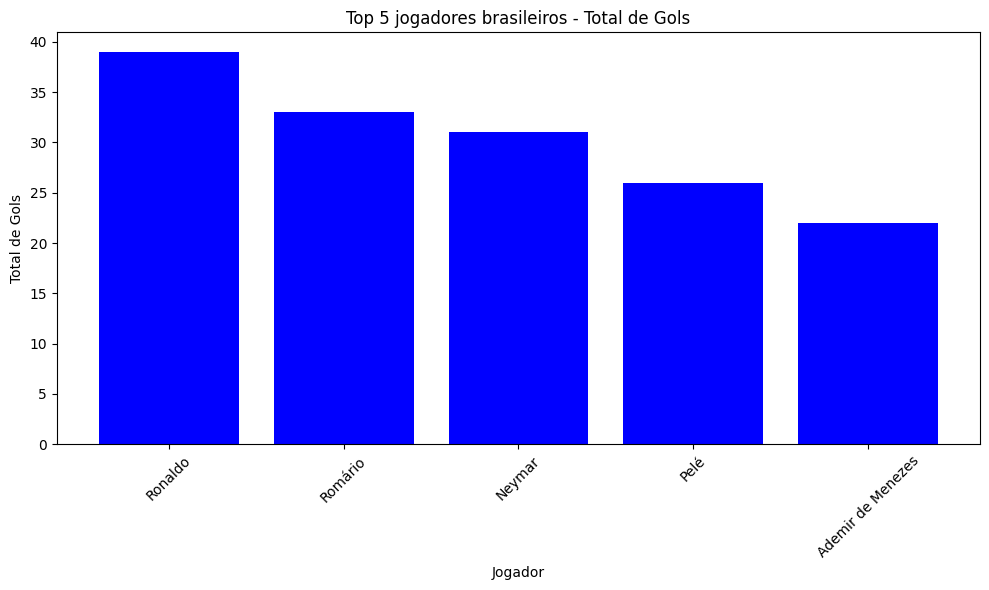

In [19]:
#5. Qual jogador brasileiro fez mais gols de penalti?

import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar o dataset
goalscorers = pd.read_csv('datasets\\goalscorers.csv')

# 2. Filtrar os gols marcados por jogadores brasileiros
gols_brasileiros = goalscorers[goalscorers['team'] == 'Brazil'].copy()

# 3. Tratar as colunas 'penalty' e 'own_goal'
# Converter as colunas 'penalty' e 'own_goal' para booleano
gols_brasileiros['penalty'] = gols_brasileiros['penalty'].astype(bool)
gols_brasileiros['own_goal'] = gols_brasileiros['own_goal'].astype(bool)

# Remover gols contra (own goals) marcados a favor do Brasil
gols_brasileiros = gols_brasileiros[~gols_brasileiros['own_goal']]

# 4. Perguntar ao usuário qual estatística deseja visualizar
print("Escolha a categoria de gols que deseja analisar:")
print("1 - Jogador com mais gols totais")
print("2 - Jogador com mais gols de pênalti")
print("3 - Jogador com mais gols de não pênalti")
while True:
    escolha = input("Digite 1, 2 ou 3: ").strip()
    if escolha in ['1', '2', '3']:
        break
    else:
        print("Opção inválida. Por favor, digite 1, 2 ou 3.")

# 5. Calcular as estatísticas de gols por jogador
# 5.1 Total de gols por jogador
total_gols = gols_brasileiros.groupby('scorer').size().reset_index(name='Total de Gols')

# 5.2 Total de gols de pênalti por jogador
gols_penalti = gols_brasileiros[gols_brasileiros['penalty']]
total_gols_penalti = gols_penalti.groupby('scorer').size().reset_index(name='Gols de Pênalti')

# 5.3 Total de gols de não pênalti por jogador
gols_nao_penalti = gols_brasileiros[~gols_brasileiros['penalty']]
total_gols_nao_penalti = gols_nao_penalti.groupby('scorer').size().reset_index(name='Gols de Não Pênalti')

# 6. Combinar as estatísticas em um único DataFrame
estatisticas = total_gols.merge(total_gols_penalti, on='scorer', how='left')
estatisticas = estatisticas.merge(total_gols_nao_penalti, on='scorer', how='left')

# Preencher valores NaN com zero
estatisticas.fillna(0, inplace=True)

# Converter colunas de contagem para inteiros
estatisticas['Gols de Pênalti'] = estatisticas['Gols de Pênalti'].astype(int)
estatisticas['Gols de Não Pênalti'] = estatisticas['Gols de Não Pênalti'].astype(int)

# 7. Ordenar o DataFrame de acordo com o critério escolhido e critérios secundários
if escolha == '1':
    # Jogador com mais gols totais
    estatisticas = estatisticas.sort_values(
        by=['Total de Gols', 'Gols de Pênalti', 'Gols de Não Pênalti'],
        ascending=[False, False, False]
    )
    criterio_principal = 'Total de Gols'
elif escolha == '2':
    # Jogador com mais gols de pênalti
    estatisticas = estatisticas.sort_values(
        by=['Gols de Pênalti', 'Total de Gols', 'Gols de Não Pênalti'],
        ascending=[False, False, False]
    )
    criterio_principal = 'Gols de Pênalti'
else:
    # Jogador com mais gols de não pênalti
    estatisticas = estatisticas.sort_values(
        by=['Gols de Não Pênalti', 'Total de Gols', 'Gols de Pênalti'],
        ascending=[False, False, False]
    )
    criterio_principal = 'Gols de Não Pênalti'

# 8. Exibir o jogador com o maior número de gols na categoria escolhida
top_jogador = estatisticas.iloc[0]
print(f"\nJogador brasileiro com mais {criterio_principal.lower()}:")
print(f"{top_jogador['scorer']} - {top_jogador[criterio_principal]} {criterio_principal.lower()}")

# 9. Exibir o DataFrame completo com todos os jogadores
print("\nEstatísticas de todos os jogadores:")
print(estatisticas.to_string(index=False))

# 10. Plotar o gráfico de barras com o top 5 jogadores da categoria escolhida
top5 = estatisticas.head(5)

plt.figure(figsize=(10,6))
plt.bar(top5['scorer'], top5[criterio_principal], color='blue')
plt.xlabel('Jogador')
plt.ylabel(criterio_principal)
plt.title(f"Top 5 jogadores brasileiros - {criterio_principal}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Deseja incluir amistosos na análise? (S/N):  S



Escolha a categoria para análise dos gols:
1 - Times que mais tomaram gols do Brasil (total)
2 - Times que mais tomaram gols do Brasil quando o Brasil era mandante
3 - Times que mais tomaram gols do Brasil quando o Brasil era visitante


Digite 1, 2 ou 3:  1



Deseja que os gols sejam:
1 - Gols absolutos
2 - Gols por jogo (média de gols por partida)


Digite 1 ou 2:  1



Os times que mais tomaram gols do Brasil (Total de gols sofridos contra o Brasil):
Paraguay: 182 gols em 83 jogos
Chile: 171 gols em 75 jogos
Argentina: 165 gols em 109 jogos
Uruguay: 140 gols em 78 jogos
Peru: 114 gols em 52 jogos

Estatísticas completas:
            adversario  jogos  gols_brasil
              Paraguay     83          182
                 Chile     75          171
             Argentina    109          165
               Uruguay     78          140
                  Peru     52          114
               Bolivia     33          113
               Ecuador     35           98
             Venezuela     29           97
                Mexico     42           78
              Colombia     37           69
         United States     20           42
              Portugal     21           41
               Germany     23           41
                Poland     12           37
                Sweden     15           35
                 Japan     13           35
           

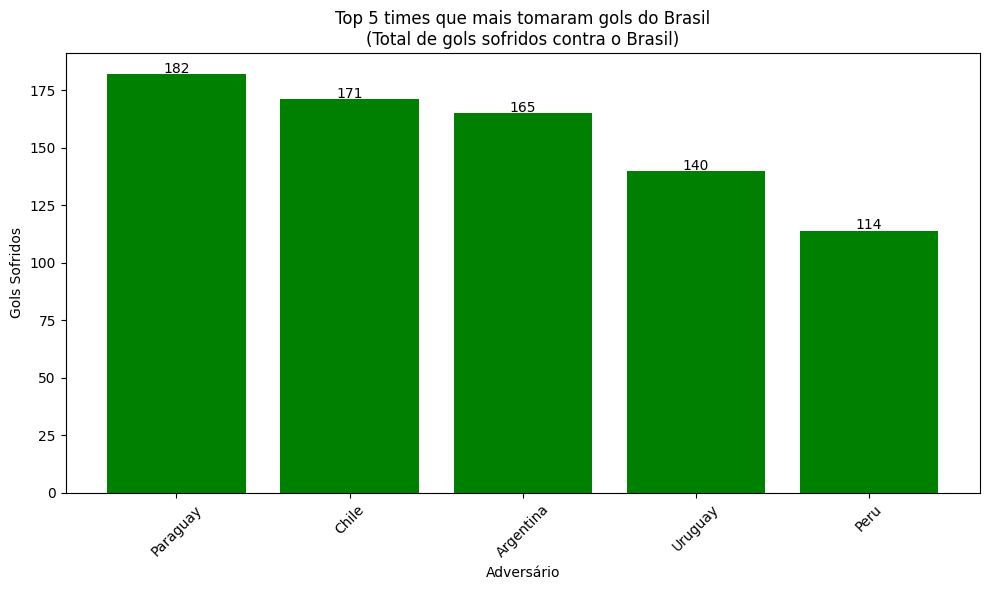

In [21]:
#6. Quais os 5 times que mais tomaram gols do Brasil? (Dica: esse seria legal um gráfico de barras vertical)

import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar o dataset
results = pd.read_csv('datasets\\results.csv')

# 2. Filtrar as partidas em que o Brasil participou (como mandante ou visitante)
df_brasil = results[(results['home_team'] == 'Brazil') | (results['away_team'] == 'Brazil')].copy()

# 3. Perguntar ao usuário se deseja incluir amistosos
incluir_amistosos = input("Deseja incluir amistosos na análise? (S/N): ").strip().upper()

# 4. Filtrar as partidas com base na escolha do usuário
if incluir_amistosos == 'N':
    df_brasil = df_brasil[df_brasil['tournament'] != 'Friendly']
elif incluir_amistosos == 'S':
    pass  # Não precisa filtrar, pois já inclui todos os jogos
else:
    print("Opção inválida. Considerando apenas partidas não amistosas por padrão.")
    df_brasil = df_brasil[df_brasil['tournament'] != 'Friendly']

# 5. Perguntar ao usuário qual opção deseja analisar
print("\nEscolha a categoria para análise dos gols:")
print("1 - Times que mais tomaram gols do Brasil (total)")
print("2 - Times que mais tomaram gols do Brasil quando o Brasil era mandante")
print("3 - Times que mais tomaram gols do Brasil quando o Brasil era visitante")
while True:
    opcao = input("Digite 1, 2 ou 3: ").strip()
    if opcao in ['1', '2', '3']:
        break
    else:
        print("Opção inválida. Por favor, digite 1, 2 ou 3.")

# 6. Perguntar ao usuário se deseja gols absolutos ou relativos ao número de jogos
print("\nDeseja que os gols sejam:")
print("1 - Gols absolutos")
print("2 - Gols por jogo (média de gols por partida)")
while True:
    opcao_gols = input("Digite 1 ou 2: ").strip()
    if opcao_gols in ['1', '2']:
        break
    else:
        print("Opção inválida. Por favor, digite 1 ou 2.")

# 7. Criar colunas auxiliares para os gols marcados pelo Brasil em cada partida
df_brasil['gols_brasil'] = df_brasil.apply(
    lambda row: row['home_score'] if row['home_team'] == 'Brazil' else row['away_score'], axis=1)
df_brasil['adversario'] = df_brasil.apply(
    lambda row: row['away_team'] if row['home_team'] == 'Brazil' else row['home_team'], axis=1)
df_brasil['mandante'] = df_brasil['home_team'] == 'Brazil'
df_brasil['visitante'] = df_brasil['away_team'] == 'Brazil'

# 8. Selecionar os dados conforme a opção escolhida
if opcao == '1':
    # Todas as partidas
    df_selecionado = df_brasil.copy()
    criterio = 'Total de gols sofridos contra o Brasil'
elif opcao == '2':
    # Partidas com o Brasil como mandante
    df_selecionado = df_brasil[df_brasil['mandante']].copy()
    criterio = 'Gols sofridos do Brasil como mandante'
else:
    # Partidas com o Brasil como visitante
    df_selecionado = df_brasil[df_brasil['visitante']].copy()
    criterio = 'Gols sofridos do Brasil como visitante'

# 9. Calcular os gols e o número de jogos por adversário
gols_por_adversario = df_selecionado.groupby('adversario').agg(
    gols_brasil=('gols_brasil', 'sum'),
    jogos=('adversario', 'count')
).reset_index()

# 10. Calcular gols por jogo se o usuário escolheu a opção 2
if opcao_gols == '2':
    gols_por_adversario['gols_por_jogo'] = gols_por_adversario['gols_brasil'] / gols_por_adversario['jogos']
    # Arredondar para uma casa decimal
    gols_por_adversario['gols_por_jogo'] = gols_por_adversario['gols_por_jogo'].round(1)
    # Ordenar pelos gols por jogo
    gols_por_adversario = gols_por_adversario.sort_values(by='gols_por_jogo', ascending=False)
    coluna_grafico = 'gols_por_jogo'
    ylabel = 'Gols por Jogo'
    titulo_grafico = f"Top 5 times que mais tomaram gols por jogo do Brasil\n({criterio})"
else:
    # Ordenar pelos gols absolutos
    gols_por_adversario = gols_por_adversario.sort_values(by='gols_brasil', ascending=False)
    coluna_grafico = 'gols_brasil'
    ylabel = 'Gols Sofridos'
    titulo_grafico = f"Top 5 times que mais tomaram gols do Brasil\n({criterio})"

# 11. Selecionar os top 5 adversários
top5 = gols_por_adversario.head(5)

# 12. Mostrar a resposta direta para a pergunta
print(f"\nOs times que mais tomaram gols do Brasil ({criterio}):")
if opcao_gols == '2':
    for index, row in top5.iterrows():
        print(f"{row['adversario']}: {row['gols_por_jogo']:.1f} gols por jogo em {row['jogos']} jogos")
else:
    for index, row in top5.iterrows():
        print(f"{row['adversario']}: {row['gols_brasil']} gols em {row['jogos']} jogos")

# 13. Mostrar o dataset com as estatísticas calculadas
print("\nEstatísticas completas:")
if opcao_gols == '2':
    # Ordenar para exibir todo o dataset corretamente
    gols_por_adversario = gols_por_adversario.sort_values(by='gols_por_jogo', ascending=False)
    print(gols_por_adversario[['adversario', 'jogos', 'gols_brasil', 'gols_por_jogo']].to_string(index=False))
else:
    gols_por_adversario = gols_por_adversario.sort_values(by='gols_brasil', ascending=False)
    print(gols_por_adversario[['adversario', 'jogos', 'gols_brasil']].to_string(index=False))

# 14. Exibir o gráfico de barras pertinente à opção escolhida
plt.figure(figsize=(10,6))
if opcao_gols == '2':
    plt.bar(top5['adversario'], top5[coluna_grafico], color='green')
    plt.ylabel(ylabel)
    # Adicionar os valores acima das barras com uma casa decimal
    for i, v in enumerate(top5[coluna_grafico]):
        plt.text(i, v + 0.05, f"{v:.1f}", ha='center')
else:
    plt.bar(top5['adversario'], top5[coluna_grafico], color='green')
    plt.ylabel(ylabel)
    # Adicionar os valores acima das barras
    for i, v in enumerate(top5[coluna_grafico]):
        plt.text(i, v + 0.5, str(int(v)), ha='center')
plt.xlabel('Adversário')
plt.title(titulo_grafico)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
